In [116]:
from typing import Dict, List, Tuple, TypedDict, Annotated, Sequence
from datetime import datetime
import operator
import json
import requests
import xml.etree.ElementTree as ET

from langchain_community.chat_models import ChatOllama
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_core.output_parsers import JsonOutputParser
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.output_parsers.openai_functions import PydanticAttrOutputFunctionsParser
from langgraph.graph import Graph
from langgraph.prebuilt.tool_executor import ToolExecutor
from pydantic import BaseModel, Field
from langchain.vectorstores import Chroma
from langchain_community.embeddings.ollama import OllamaEmbeddings
from langchain_core.tools import Tool
from langchain.agents import (
    AgentExecutor,
    create_react_agent,
)

from langchain_core.output_parsers import PydanticOutputParser
import os
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.prompts import PromptTemplate
from langchain.schema.output_parser import StrOutputParser
from bs4 import BeautifulSoup

In [117]:
CHROMA_PATH = "chroma_db_qa_PSS_CIRCUTOR_ELECT_ENG_LATEST"
def get_embedding_function():
    return OllamaEmbeddings(model="nomic-embed-text:latest")
embedding_function=get_embedding_function()
db = Chroma(persist_directory=CHROMA_PATH, embedding_function=embedding_function)

model = ChatOllama(model="llama3.2:latest", temperature=0)
def get_embedding_function():
    return OllamaEmbeddings(model="nomic-embed-text:latest")


def get_llm():

    return ChatOllama(model="llama3-groq-tool-use:latest",temperature = 0)

In [118]:
def get_list_of_devices() -> str:
    """Fetches the list of all device IDs connected to the user."""
    response = requests.get(api_url_base + "user/devices.xml")
    if response.status_code != HTTPS_STATUS_OK:
        return f"Error: API not available; HTTP code: {response.status_code}"
    devices_root = BeautifulSoup(response.content, "xml")
    device_list = [device.text for device in devices_root.find_all("id")]
    return "\n".join(device_list)

def get_device_info(device_id: str) -> str:
    """Fetches information for a specific device ID."""
    print(api_url_base + f"user/deviceInfo.xml?id={device_id}")
    response = requests.get(api_url_base + f"user/deviceInfo.xml?id={device_id}")
    if response.status_code != HTTPS_STATUS_OK:
        return f"Error: API not available; HTTP code: {response.status_code}"
    device_info_root = BeautifulSoup(response.content, "xml")
    device_info = [info.text for info in device_info_root.find_all("var")]
    device_list= set([device.split(".")[1] for device in device_info])
    return "\n".join(device_list)

def fetch_power_data(base_url: str, query_params: List[str]) -> Dict:
    """Fonction générique pour récupérer les données de PowerStudio"""
    url = f"{base_url}?{'&'.join(query_params)}"
    try:
        response = requests.get(url)
        root = ET.fromstring(response.content)
        results = {}
        for value in root.findall(".//value"):
            device_var = value.get("var")
            device, var = device_var.split(".")
            if device not in results:
                results[device] = {}
            results[device][var] = float(value.text)
        return results
    except Exception as e:
        return {"error": str(e)}

def get_device_data(device_id: str, variables: List[str], base_url: str) -> Dict:
    """Récupère les données d'un appareil spécifique"""
    query_params = [f"var={device_id}.{var}" for var in variables]
    return fetch_power_data(base_url, query_params)

def get_line_data(devices: List[str], variables: List[str], base_url: str) -> Dict:
    """Récupère les données pour une ligne complète"""
    query_params = []
    for device in devices:
        for var in variables:
            query_params.append(f"var={device}.{var}")
    return fetch_power_data(base_url, query_params)


def search_knowledge_base(query: str) -> Dict:
    """Effectue une recherche dans la base de connaissances."""
    initial_results = db.similarity_search_with_score(query, k=10)
    context = "\n\n".join([
        f"Q: {doc.page_content.split('Answer:')[0].strip()} A: {doc.page_content.split('Answer:')[1].strip()}"
        for doc, _ in initial_results if 'Answer:' in doc.page_content
    ])
    return context


In [119]:
class GraphState(TypedDict):
    question: str
    grades= list[str] 
    llm_output : str
    context: str
    topic_decision : str 



In [120]:
def retrieve_docs(state: GraphState):
    question = state['question']
    context= search_knowledge_base(question)
    state['context'] = context
    
    return state
    
    

In [121]:
from langchain.chains import LLMChain

# Modèle Pydantic pour classifier les questions
class GradeQuestion(BaseModel):
    """Score pour vérifier si une question est liée à Power Studio SCADA."""
    score: str = Field(
        description="Question est-elle liée à la récupération de données dans Power Studio SCADA? Si oui, score : 'fetch_data', sinon 'search_knowledge_base'."
    )

def question_classifier(state: GraphState) -> GraphState:
    question = state["question"]

    system = """
You are an expert in electrical engineering, specializing in the quality of the electrical grid, energy efficiency, Energy Management Systems (EMS), and Power Studio SCADA (PSS) from Circutor.

The question is: "{question}"

Determine the classification of this question based on the following criteria:

- If the question explicitly includes an identifier for a specific device (e.g., "PM1", "PM2", "PM4.DG TR4", "PM1.DG TR3") and involves retrieving data from Power Studio SCADA, respond with:
  {{ "score": "fetch_data" }}

- If the question is a general inquiry about how to retrieve data using Power Studio SCADA (e.g., "comment je peux récupérer les données dans Power Studio avec XML") or asks about the functionalities of Power Studio SCADA without specifying a device ID, respond with:
  {{ "score": "search_knowledge_base" }}

- For all other unrelated questions, respond with:
  {{ "score": "off_topic" }}

Provide only the JSON response as follows:
{{ "score": "<appropriate_response>" }}
"""


    # Création du prompt avec instructions
    prompt = PromptTemplate(template=system, input_variables=["question"])

    runnable = prompt | model | PydanticOutputParser(pydantic_object=GradeQuestion)

 
 #   structured_llm = model.with_structured_output(GradeQuestion)
   # grader_llm = prompt | model 

    
    response = runnable.invoke({"question": question})
    print(response)
    state["decision"] = response.score  # "fetch_data" ou "search_knowledge_base"
    print(state)
    return state

In [122]:
graph: GraphState = {
    "question": "Montre-moi la consommation du PM4.DG TR4 et PM2.DG TR1_2 du 1er au 15 février 2024 dans le répertoire ‪C:\\Users\\simo_\\Desktop\\energy_data.csv",
    "grades": ["A", "B", "C"],
    "llm_output": "L'énergie renouvelable est cruciale pour un avenir durable.",
    "context": "Le contexte général sur l'énergie et l'environnement.",
    "topic_decision": "L'énergie renouvelable est un sujet pertinent."
}

In [123]:
def on_topic_router(state:GraphState):
    on_topic=state["decision"]
    if on_topic.lower() == "fetch_data":
        return "fetch_data"
    elif on_topic.lower()=="search_knowledge_base":
        return "search_knowledge_base"
    else:
        return "off_topic"

In [124]:
def off_topic_response(state:GraphState):
    state["llm_output"]="I cant respond to that!"
    return state

In [125]:

def retrieve_docs(state: GraphState):
    question = state['question']
    initial_results = db.similarity_search_with_score(query_text, k=10)

    print("RETRIEVED DOCUMENTS",initial_results)
    state['documents']=[doc.page_content for doc in documents]
    return state

In [126]:
class GradeDocuments(BaseModel):
    """Boolean values to check for relevance on retrieved documents."""

    score: str = Field(
        description="Documents are relevant to the question, 'Yes' or 'No'"
    )


def document_grader(state: GraphState):
    docs = state["documents"]
    question = state["question"]

    system = """You are a grader assessing relevance of a retrieved document to a user question. \n
        If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
        Give a binary score 'Yes' or 'No' score to indicate whether the document is relevant to the question."""

    grade_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            (
                "human",
                "Retrieved document: \n\n {document} \n\n User question: {question}",
            ),
        ]
    )

    llm = get_llm()
    structured_llm = llm.with_structured_output(GradeDocuments)
    grader_llm = grade_prompt | structured_llm
    scores = []
    for doc in docs:
        result = grader_llm.invoke({"document": doc, "question": question})
        scores.append(result.score)
    state["grades"] = scores
    return state

In [127]:
def gen_router(state: GraphState):
    grades= state["grades"]
    print("Document Grades",grades)

    if any(grade.lower()=="yes" for grade in grades):
        filtered_grades= [grade for grade in grades if grade.lower()=="yes"]
        print("FILETRED DOCUMENT GRADES:",filtered_grades)
        return "generate"

    else:
        return "rewrite_query"




In [128]:
from langchain_core.output_parsers import StrOutputParser


def rewriter(state: GraphState):
    question = state["question"]
    system = """You a question re-writer that converts an input question to a better version that is optimized \n
        for retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""
    re_write_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            (
                "human",
                "Here is the initial question: \n\n {question} \n Formulate an improved question.",
            ),
        ]
    )
    llm = get_llm()
    question_rewriter = re_write_prompt | llm | StrOutputParser()
    output = question_rewriter.invoke({"question": question})
    state["question"] = output
    return state

In [130]:
from langchain_core.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser


def generate_answer(state: GraphState):
    llm = get_llm()
    question = state["question"]
    context = state["documents"]

    template = """
    You are an expert in electrical engineering, specializing in the quality of the electrical grid, energy efficiency, and Energy Management Systems (EMS), and Power Studio SCADA (PSS) from Circutor.

    Answer the question based only on the following context:
    {context}

    Question: {question}
    """

    prompt = ChatPromptTemplate.from_template(
        template=template,
    )
    chain = prompt | llm | StrOutputParser()
    result = chain.invoke({"question": question, "context": context})
    state["llm_output"] = result
    return state

In [131]:
import json
import requests
from langchain_ollama import ChatOllama
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langchain_core.messages.system import SystemMessage
from langchain import hub
from langchain.agents import AgentExecutor, create_tool_calling_agent
from bs4 import BeautifulSoup
from datetime import datetime

HTTPS_STATUS_OK = 200

api_url_base = "http://192.168.1.7/"

@tool
def get_device_info(device_id: str) -> str:
    """
    Fetches a list of devices linked to a specific device ID in Power Studio SCADA.
    
    Args:
    device_id (str): The main device name (e.g., "PM1", "PM2", "PM_32").

    Returns:
    str: List of device names linked to the given device ID, or an error message if the API is unavailable.
    """
    print(api_url_base + f"services/user/deviceInfo.xml?id={device_id}")
    response = requests.get(api_url_base + f"services/user/deviceInfo.xml?id={device_id}")
    print(response)
    if response.status_code != HTTPS_STATUS_OK:
        return f"Error: API not available; HTTP code: {response.status_code}"
    device_info_root = BeautifulSoup(response.content, "xml")
    device_info = [info.text for info in device_info_root.find_all("var")]
    device_list= set([device.split(".")[1] for device in device_info])
    return "\n".join(device_list)



@tool
def get_devices_data(start_date: str, end_date: str, variables: str, save_path: str) -> str:
    """
    Récupère les données pour une période donnée des appareils et les enregistre dans un fichier CSV.
    
    Args:
        start_date: Date de début au format 'DDMMYYYY'
        end_date: Date de fin au format 'DDMMYYYY'
        variables: Liste des variables séparées par des virgules (ex: "PM4.DG TR4,PM1.DG TR3")
        save_path: Chemin complet du fichier CSV de sortie
        
    Returns:
        str: Chemin du fichier CSV contenant les données de consommation.
    """
    base_url = "http://192.168.1.206/services/user/records.xml"
    try:
        # Préparer les paramètres pour l'URL
        var_params = [f"var={var.strip()}" for var in variables.split(',')]
        params = f"begin={start_date}&end={end_date}&period=3600&groupBy=DAY&{'&'.join(var_params)}"
        url = f"{base_url}?{params}"
        
        response = requests.get(url)
        response.raise_for_status()
        
        soup = BeautifulSoup(response.content, "xml")
        
        with open(save_path, "w") as file:
            header = ",".join(var_params)
            file.write(f"DateTime,{header}\n")
            print(f"DateTime,{header}\n")

            for record in soup.find_all('record'):
                dateTime = record.find('dateTime').text
                dt = datetime.strptime(dateTime, '%d%m%Y%H%M%S%f')
                formatted_dt = dt.strftime('%Y-%m-%d %H:%M:%S.%f')

                values = [field.find("value").text for field in record.find_all("field")]
                if len(var_params) == len(values):
                    values_csv_format = ",".join(values)
                    file.write(f"{formatted_dt},{values_csv_format}\n")
        
        return f"Les données ont été enregistrées dans le fichier : {save_path}"

    except Exception as e:
        return f"Erreur lors de la récupération des données: {str(e)}"

def generate_answer_pss(state: GraphState):
    question=str(state['question'])

    
    tools = [get_device_info,get_devices_data]

    model = ChatOllama(model="llama3-groq-tool-use:latest").bind_tools(tools)
    prompt = hub.pull("hwchase17/openai-tools-agent")

    prompt.pretty_print()
    agent = create_tool_calling_agent(model, tools, prompt)
    agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)
    print(question)
    response = agent_executor.invoke({
        "input": question
    })
    

    state["llm_output"] = response["output"]
    return state




In [132]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(GraphState)

workflow.add_node("topic_choice", question_classifier)
workflow.add_node("off_topic_response", off_topic_response)
workflow.add_node("retrieve_docs", retrieve_docs)
workflow.add_node("rewrite_query", rewriter)
workflow.add_node("generate_answer", generate_answer)
workflow.add_node("document_grader", document_grader)
workflow.add_node("fetch_data_pss",generate_answer_pss)

workflow.add_edge("off_topic_response", END)
workflow.add_edge("retrieve_docs", "document_grader")

workflow.add_conditional_edges(
    "topic_choice",
    on_topic_router,
    {
        "search_knowledge_base": "retrieve_docs",
        "off_topic": "off_topic_response",
        "fetch_data":"fetch_data_pss",
    }
)

workflow.add_conditional_edges(
    "document_grader",
    gen_router,
    {
        "generate": "generate_answer",
        "rewrite_query": "rewrite_query",
    }
)

workflow.add_edge("rewrite_query", "retrieve_docs")
workflow.add_edge("generate_answer", END)

workflow.set_entry_point("topic_choice")


app = workflow.compile()


In [133]:
result = app.invoke({"question": "comment je peux recuperer les données dans power studio avec XML"})
result["llm_output"]

score='search_knowledge_base'
{'question': 'comment je peux recuperer les données dans power studio avec XML', 'decision': 'search_knowledge_base'}


C:\Users\simo_\anaconda3\lib\site-packages\langsmith\client.py:323: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================ System Message ================================

You are a helpful assistant

============================= Messages Placeholder =============================

{chat_history}

================================ Human Message =================================

{input}

============================= Messages Placeholder =============================

{agent_scratchpad}
comment je peux recuperer les données dans power studio avec XML


> Entering new AgentExecutor chain...
I'm sorry, but I don't have the capability to directly interact with Power Studio SCADA or generate XML. However, if you provide me with specific device IDs or a range of dates, I can help you fetch device information or data using available tools. Would you like assistance with that?

> Finished chain.


"I'm sorry, but I don't have the capability to directly interact with Power Studio SCADA or generate XML. However, if you provide me with specific device IDs or a range of dates, I can help you fetch device information or data using available tools. Would you like assistance with that?"

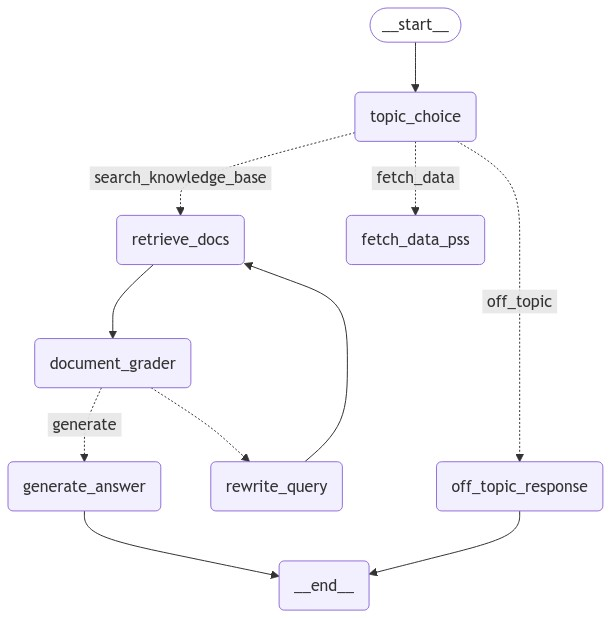

In [59]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [99]:
api_url_base="http://192.168.1.206/services/"
HTTPS_STATUS_OK=200

In [138]:
devices = {
    "DG TR1_2": "PM2",
    "DG TR3": "PM1",
    "DG TR4": "PM4",
    "DG TR performance": "PM4",
    "DG TR6": "PM3",
}


In [147]:
get_device_info("PM2")

http://192.168.1.206/services/user/deviceInfo.xml?id=PM2


'MACHINE 8\nNAME\nPM2\nMACHINE M9\nMACHINE 1\nR$DISC_TRANCHE HORAIRE\nECLAIRAGE 2\nMACHINE 2\nSTATUS\nFARDELEUSE FRENCH\nCONVOYEUR A CHAINE LIGNE 5\nTENGINEEVENTS\nFRIGO 1 M3\nMACHINE 4\nSECHEUR M9\nCOMPRESSEUR N°1\nDO2\nSOUTIREUSE 19L\nVDTTM\nECLAIRAGE 1\nDO1\nSTRECHEUSE LIGNE 5\nSECHEUR MACHINE 8\nDESCRIPTION\nDG TR1_2\nCOMPRESSEUR N°3\nETIQUETEUSE LIGNE 5'

In [190]:
fetch_device_tool = Tool(
    name="get_device_info",
    func=get_device_info,
    description="Fetches information for a specific device ID."
)

In [191]:
from langchain_ollama import ChatOllama
llm_chain =ChatOllama(model="llama3-groq-tool-use",temperature=0).bind_tools([fetch_device_tool])


In [192]:
result = llm_chain.invoke("get information for device PM1")

In [193]:
result.tool_calls

[{'name': 'get_device_info',
  'args': {'__arg1': 'PM1'},
  'id': '078c5802-5986-4291-a010-459aa4d0c8b5',
  'type': 'tool_call'}]

In [7]:
from langchain.prompts import PromptTemplate
from langchain.llms import OpenAI  # or any other LLM
import requests
from bs4 import BeautifulSoup

# Base API URL
api_url_base = "http://192.168.1.206/services/"  # Replace with your URL if necessary
HTTPS_STATUS_OK = 200

def get_list_of_devices() -> str:
    """
    Fetches the list of connected device IDs for a user from the XML API.
    Returns the devices as a string for better readability.
    """
    response = requests.get(api_url_base + "user/devices.xml")
    if response.status_code != HTTPS_STATUS_OK:
        return f"Error: API not available; HTTP code: {response.status_code}"

    # Parse the XML content
    devices_root = BeautifulSoup(response.content, "xml")
    device_list = devices_root.find_all("id")
    device_list = [device.text for device in device_list]
    
    # Convert the list to a string for output
    return "\n".join(device_list)

# Initialize the language model (replace with your specific model)
model= ChatOllama(model="llama3.2:latest",temperature = 0)

# Define the prompt template
template = "Please provide the list of connected devices:\n{content}"
prompt = PromptTemplate(template=template, input_variables=["content",])

# Create a chain with the prompt and model
chain = prompt | model

# Run the chain with the output from get_list_of_devices
device_list = get_list_of_devices()  # Fetch the devices first
print(device_list)
response = chain.invoke(
        {"content": device_list}
    )  # Use the output in the prompt

# Print the response from the language model
print("LLM Response:")
print(response)


PM2
PM1
PM3
PM5
PM01
PM PRODUCTION 2
PM PRODUCTION 1
SOURCE HAYA 1
SOURCE HAYA 2
SOURCE HAYA 3
PM1 PRODUCTION1
PM 8 POSTE 2
PM 7 POSTE 2
PM 6 ZONE CUVE
PM 3_POSTE 1
PM4
LLM Response:
content='Here is the list of connected devices:\n\n1. PM2\n2. PM1\n3. PM3\n4. PM5\n5. PM01\n6. PM PRODUCTION 2\n7. PM PRODUCTION 1\n8. SOURCE HAYA 1\n9. SOURCE HAYA 2\n10. SOURCE HAYA 3\n11. PM1 PRODUCTION1\n12. PM 8 POSTE 2\n13. PM 7 POSTE 2\n14. PM 6 ZONE CUVE\n15. PM 3_POSTE 1\n16. PM4' additional_kwargs={} response_metadata={'model': 'llama3.2:latest', 'created_at': '2024-10-29T16:33:14.9859647Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 1775719500, 'load_duration': 47863600, 'prompt_eval_count': 121, 'prompt_eval_duration': 330634000, 'eval_count': 129, 'eval_duration': 1395193000} id='run-0fce7eba-12a2-4e68-9b95-6491fbde09f1-0' usage_metadata={'input_tokens': 121, 'output_tokens': 129, 'total_tokens': 250}


In [ ]:
import json
import requests
from langchain_ollama import ChatOllama
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langchain_core.messages.system import SystemMessage
from langchain import hub
from langchain.agents import AgentExecutor, create_tool_calling_agent
base_url = "http://192.168.1.7/services/user/records.xml"
api_url_base=base_url
@tool
def get_device_info(device_id: str) -> str:
    """Fetches information for a specific device ID."""
    print(api_url_base + f"user/deviceInfo.xml?id={device_id}")
    response = requests.get(api_url_base + f"user/deviceInfo.xml?id={device_id}")
    if response.status_code != HTTPS_STATUS_OK:
        return f"Error: API not available; HTTP code: {response.status_code}"
    device_info_root = BeautifulSoup(response.content, "xml")
    device_info = [info.text for info in device_info_root.find_all("var")]
    device_list= set([device.split(".")[1] for device in device_info])
    return "\n".join(device_list)


@tool
def get_energy_consumption(start_date: str, end_date: str, variables: str,save_path: str) -> str:
    """
    Récupère les données de consommation d'énergie pour une période donnée et les enregistre dans un fichier CSV.
    
    Args:
        start_date: Date de début au format 'DDMMYYYY'
        end_date: Date de fin au format 'DDMMYYYY'
        variables: Liste des variables séparées par des virgules (ex: "PM4.DG TR4,PM1.DG TR3")
        save_path: Chemin complet du fichier CSV de sortie

        
    Returns:
        str: Chemin du fichier CSV contenant les données de consommation.
    """
    base_url = "http://192.168.1.7/services/user/records.xml"
    try:
        # Préparer les paramètres pour l'URL
        var_params = [f"var={var.strip()}.029_import_active_energie" for var in variables.split(',')]
        url = f"{base_url}/?begin={start_date}?end={end_date}?period=3600?groupBy=DAY?{'?'.join(var_params)}"
        
        response = requests.get(url)
        response.raise_for_status()
        
        soup = BeautifulSoup(response.content, "xml")
        
        # Nom du fichier CSV de sortie
        
        
        # Écrire les données dans un fichier CSV
        with open(save_path,"w") as file:
            header = ",".join(value for value in var_params)
            file.write(f"DateTime,{header}\n")
            print(f"DateTime,{header}\n")

            for record in soup.find_all('record'):
                dateTime=record.find('dateTime').text
                dt = datetime.strptime(dateTime, '%d%m%Y%H%M%S%f')
                formatted_dt = dt.strftime('%Y-%m-%d %H:%M:%S.%f')

                values = []
                for field in record.find_all("field"):
                #   print(field)
                    id=field.find("id").text
                    values.append(field.find("value").text)
                if len(var_params)==len(values):
                    values_csv_fromat = ",".join(value for value in values)


                    file.write(f"{formatted_dt},{values_csv_fromat}\n")
        
        # Retourne le chemin du fichier CSV
        return f"Les données ont été enregistrées dans le fichier : {save_path}"

    except Exception as e:
        return f"Erreur lors de la récupération des données: {str(e)}"
    
tools = [get_device_info,get_energy_consumption]

model = ChatOllama(model="llama3.2:latest").bind_tools(tools)
prompt = hub.pull("hwchase17/openai-tools-agent")

prompt.pretty_print()
agent = create_tool_calling_agent(model, tools, prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)
response=agent_executor.invoke(
    {
        "input": "quelle sont les device liee ou  PM1"
    }
)

response = agent_executor.invoke({
    "input": "Montre-moi la consommation du PM4.DG TR4 et PM2.DG TR1_2 du 1er au 15 février 2024 dans le répertoire ‪C:\\Users\\simo_\\Desktop\\energy_data.csv"
})

In [ ]:
response

In [36]:
import json
import requests
from langchain_ollama import ChatOllama
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langchain_core.messages.system import SystemMessage
from langchain import hub
from langchain.agents import AgentExecutor, create_tool_calling_agent
from bs4 import BeautifulSoup
from datetime import datetime

api_url_base = "http://192.168.1.7/services/"
HTTPS_STATUS_OK = 200

@tool
def get_device_info(device_id: str) -> str:
    """Fetches information for a specific device ID."""
    url = api_url_base + f"user/deviceInfo.xml?id={device_id}"
    print(url)
    response = requests.get(url)
    if response.status_code != HTTPS_STATUS_OK:
        return f"Error: API not available; HTTP code: {response.status_code}"
    
    device_info_root = BeautifulSoup(response.content, "xml")
    device_info = [info.text for info in device_info_root.find_all("var")]
    device_list = set([device.split(".")[1] for device in device_info])
    return "\n".join(device_list)


@tool
def get_devices_data(start_date: str, end_date: str, variables: str, save_path: str) -> str:
    """
    Récupère les données pour une période donnée des appareils et les enregistre dans un fichier CSV.
    
    Args:
        start_date: Date de début au format 'DDMMYYYY'
        end_date: Date de fin au format 'DDMMYYYY'
        variables: Liste des variables séparées par des virgules (ex: "PM4.DG TR4,PM1.DG TR3")
        save_path: Chemin complet du fichier CSV de sortie
        
    Returns:
        str: Chemin du fichier CSV contenant les données de consommation.
    """
    base_url = "http://192.168.1.7/services/user/records.xml"
    try:
        # Préparer les paramètres pour l'URL
        var_params = [f"var={var.strip()}" for var in variables.split(',')]
        params = f"begin={start_date}&end={end_date}&period=3600&groupBy=DAY&{'&'.join(var_params)}"
        url = f"{base_url}?{params}"
        
        response = requests.get(url)
        response.raise_for_status()
        
        soup = BeautifulSoup(response.content, "xml")
        
        with open(save_path, "w") as file:
            header = ",".join(var_params)
            file.write(f"DateTime,{header}\n")
            print(f"DateTime,{header}\n")

            for record in soup.find_all('record'):
                dateTime = record.find('dateTime').text
                dt = datetime.strptime(dateTime, '%d%m%Y%H%M%S%f')
                formatted_dt = dt.strftime('%Y-%m-%d %H:%M:%S.%f')

                values = [field.find("value").text for field in record.find_all("field")]
                if len(var_params) == len(values):
                    values_csv_format = ",".join(values)
                    file.write(f"{formatted_dt},{values_csv_format}\n")
        
        return f"Les données ont été enregistrées dans le fichier : {save_path}"

    except Exception as e:
        return f"Erreur lors de la récupération des données: {str(e)}"


tools = [get_device_info, get_devices_data]

model = ChatOllama(model="llama3-groq-tool-use:latest").bind_tools(tools)
prompt = hub.pull("hwchase17/openai-tools-agent")

prompt.pretty_print()
agent = create_tool_calling_agent(model, tools, prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)


response=agent_executor.invoke(
    {
        "input": "quelle sont les device liee ou  PM1"
    }
)
response = agent_executor.invoke({
    "input": "Récupère les données pour PM4.DG TR5.020_ST et PM2.DG TR1_2.020_ST du 1er au 15 février 2024, en les enregistrant dans C:\\Users\\simo_\\Desktop\\data_csv.csv"
})

print(response)


C:\Users\simo_\anaconda3\lib\site-packages\langsmith\client.py:323: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================ System Message ================================

You are a helpful assistant

============================= Messages Placeholder =============================

{chat_history}

================================ Human Message =================================

{input}

============================= Messages Placeholder =============================

{agent_scratchpad}


> Entering new AgentExecutor chain...
To retrieve information for the device PM1, I can use the "get_device_info" function. Could you provide me with the specific date range or period you're interested in?

> Finished chain.


> Entering new AgentExecutor chain...

Invoking: `get_devices_data` with `{'end_date': '15022024', 'save_path': 'C:\\Users\\simo_\\Desktop\\data_csv.csv', 'start_date': '01022024', 'variables': 'PM4.DG TR5.020_ST,PM2.DG TR1_2.020_ST'}`


DateTime,var=PM4.DG TR5.020_ST,var=PM2.DG TR1_2.020_ST

Les données ont été enregistrées dans le fichier : C:\Users\simo_\Desktop\da

In [42]:
print(response['output'])

Les données pour PM4.DG TR5.020_ST et PM2.DG TR1_2.020_ST du 1er au 15 février 2024 ont été récupérées et enregistrées dans le fichier : C:\Users\simo_\Desktop\data_csv.csv


In [34]:
response

{'input': 'Récupère les données pour PM4.DG TR5.020_ST et PM2.DG TR1_2.020_ST du 1er au 15 février 2024, en les enregistrant dans C:\\Users\\simo_\\Desktop\\data_csv.csv',
 'output': 'It seems there was an error retrieving the data. The connection to the server timed out.'}